In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt

# Data



*   Split the data into training and test sets



In [ ]:
# Download SPY data
df = yf.download('SPY', start='2010-01-01', end='2015-01-01')

df.columns = df.columns.droplevel(1)

# Returns
df['Returns'] = df['Close'].diff().dropna()

# Add moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_21'] = df['Close'].rolling(window=21).mean()

# Intraday Range Features
df['HL_Range'] = df['High'] - df['Low']
df['HL_Pct'] = (df['High'] - df['Low']) / df['Close']
df['OC_Change'] = df['Close'] - df['Open']

# Momentum
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

# Add Bollinger Bands
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['Upper_Band'] = df['MA_20'] + 2*df['Close'].rolling(window=20).std()
df['Lower_Band'] = df['MA_20'] - 2*df['Close'].rolling(window=20).std()

# Add RSI
gain = (df['Returns'].where(df['Returns'] > 0, 0)).rolling(window=14).mean()
loss = (-df['Returns'].where(df['Returns'] < 0, 0)).rolling(window=14).mean()
rs = gain/loss
df['RSI'] = 100 - (100 / (1 + rs))

# Add MACD
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Add rolling statistics
df['Rolling_Skew_21'] = df['Close'].rolling(window=21).skew()
df['Rolling_Kurt_21'] = df['Close'].rolling(window=21).kurt()
df['Rolling_Autocorr_5'] = df['Close'].rolling(window=5).apply(lambda x: x.autocorr(lag=1))
df['Rolling_Autocorr_21'] = df['Close'].rolling(window=21).apply(lambda x: x.autocorr(lag=1))

# Volume features
df['Vol_Change'] = df['Volume'].pct_change()
df['Vol_RollMean_5'] = df['Volume'].rolling(window=5).mean()
df['Vol_RollStd_5'] = df['Volume'].rolling(window=5).std()
df['Vol_ZScore'] = (df['Volume'] - df['Vol_RollMean_5']) / df['Vol_RollStd_5']

# Price acceleration (captures sudden moves)
df['Accel'] = df['Close'].diff().diff()

# Add time-based features
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter

# Rolling max-min difference (volatility proxy)
df['Roll_Max_Min_5'] = df['Close'].rolling(window=5).max() - df['Close'].rolling(window=5).min()

# Normalized deviation from 21-day moving average
df['ZScore_21'] = (df['Close'] - df['MA_21']) / df['Close'].rolling(21).std()

# Calculate past volatility
df['RealisedVol'] = df['Returns'].rolling(window=21).std() * np.sqrt(252)

# Rolling volatility (short- and medium-term)
df['Vol_5'] = df['Returns'].rolling(5).std() * np.sqrt(252)
df['Vol_10'] = df['Returns'].rolling(10).std() * np.sqrt(252)

# Target: Future volatility (using the original calculation shifted)
df['5DayFwdRealisedVol'] = df['Returns'].rolling(window=21).std().shift(-5) * np.sqrt(252)


df.dropna(inplace=True)


# Train-test split
df_train = df[df.index < '2014-01-01']
df_test = df[df.index >= '2014-01-01']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Standardise Features

In [ ]:
target = '5DayFwdRealisedVol'

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(df_train.drop(columns=target))
X_test_scaled = scaler.transform(df_test.drop(columns=target))



# Target values
y_train = df_train[target].values
y_test = df_test[target].values

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# Format Data for LSTM



*   Input for the LSTM network is a 3-dimensional array of the shape (nsample, ℓ, p), where the first coordinate index different training samples, the second index different lags and the last index covariates/features.
*   For instance, if we are interested to predict
the volatility in the next trading day using the 5 covariates (Open, High, Low, Close, Volume) in the previous 21 trading days, we have ℓ = 21 and p = 5.


*   The training data can be split into blocks of 22 days, where the first 21 days are used to construct one training sample and the last day used to compute the response. The following function formats the original data X and y into an array format accepted by the LSTM network.



In [ ]:
def create_lstm_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

time_steps = 21 * 3
X_train, y_train = create_lstm_dataset(X_train_scaled, y_train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(X_test_scaled, y_test_scaled, time_steps)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((922, 63, 38), (922, 1), (184, 63, 38), (184, 1))

# Build LSTM Model

In [ ]:
# Define model
model = Sequential()

# First LSTM layer (return sequences for stacking)
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(64))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile with a robust loss function
model.compile(
    loss=Huber(delta=1.0),
    optimizer=Adam(learning_rate=0.001)
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 63, 128)        │        85,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,977 (527.25 KB)

 Trainable params: 134,977 (527.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train and save history
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    shuffle=False,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 0.0513 - val_loss: 0.0028
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0111 - val_loss: 0.0012
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - loss: 0.0216 - val_loss: 9.2934e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - loss: 0.0104 - val_loss: 9.5605e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - loss: 0.0071 - val_loss: 8.1781e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - loss: 0.0072 - val_loss: 7.6849e-04
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - loss: 0.0061 - val_loss: 7.2919e-04
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - loss: 0.0030 - val_loss: 7.5480e-04
Epoch 12/100
13/1

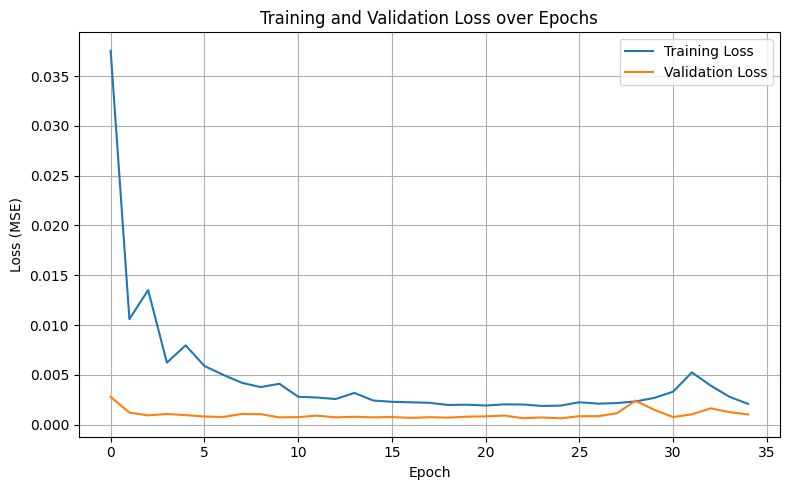

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate Model

In [ ]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

y_test_unscaled = scaler.inverse_transform(y_test)

# Spearman correlation
from scipy.stats import spearmanr
corr, _ = spearmanr(y_test_unscaled, y_pred)
print(f"Spearman correlation: {corr:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Spearman correlation: 0.9136


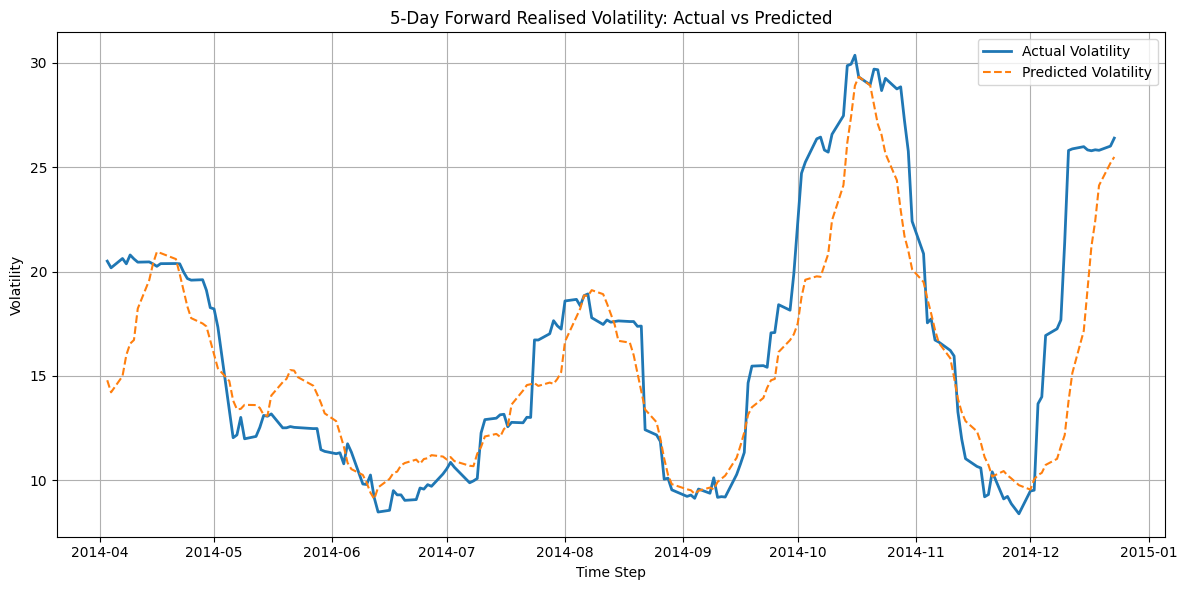

In [ ]:
time_index = df_test.index[-len(y_test_unscaled):]


plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test_unscaled, label='Actual Volatility', linewidth=2)
plt.plot(time_index, y_pred, label='Predicted Volatility', linestyle='--')
plt.title('5-Day Forward Realised Volatility: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


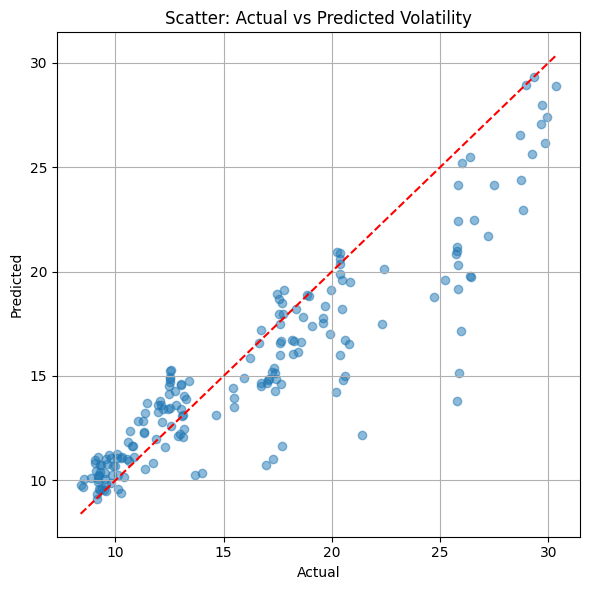

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_unscaled, y_pred, alpha=0.5)
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], 'r--')  # y = x line
plt.title('Scatter: Actual vs Predicted Volatility')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()